# Real Time Face Recognition using CNN and Transfer Learning:

# 1) Environment Check :

In [ ]:
!python --version

Python 3.11.13


In [ ]:
import tensorflow
print(tensorflow.__version__)

2.18.0


# 2) Importing Libraries :

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import os

# 3) Creating data from video :

- created data from video through jupyter

# 4) Preprocessing - Data loader from subfolders:

- It involves Data augmentation: Normalisation + rescaling + resizing + spliting into training and validation
- performed using ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/CNN Final Project/Images',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/CNN Final Project/Images',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 3600 images belonging to 5 classes.
Found 900 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/CNN Final Project/Test_Images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Helps to arrange the orders of subfolders
)

Found 500 images belonging to 5 classes.


# 5) Building model with transfer learning :

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_model(base_model_name, freeze_all=True, freeze_except=0, learning_rate=0.0001,activation='relu', num_layers=1, neurons=128, num_classes=5):

    # Loading base model without top layers (fully connected) ie., not output dense layer
    #include_top=false : It doesn't consider dense layers
    #Freeze : Not updating pretrained model weights
    if base_model_name == 'VGG16':
        base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    elif base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    else:
        print("Unknown Model")

    # Layer freezing logic
    if freeze_all:
        for layer in base_model.layers:
            layer.trainable = False
    elif freeze_except > 0:
        for layer in base_model.layers[:-freeze_except]:
            layer.trainable = False
        for layer in base_model.layers[-freeze_except:]:
            layer.trainable = True

    # Add classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x) #flattinening the vector
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x) #softmax : as multiclass classification

    model = Model(inputs=base_model.input, outputs=output) # combining pretrained and dense layer
    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = build_model('ResNet50', freeze_all=False, freeze_except=2, learning_rate=1e-4, num_classes=5)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# 6) Hyperparameter Tuning with Optuna :

In [ ]:
import optuna
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
def objective(trial):

    base_model_name = trial.suggest_categorical('base_model', ['VGG16', 'ResNet50', 'MobileNetV2'])
    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    freeze_all = trial.suggest_categorical('freeze_all', [True, False])
    freeze_except = trial.suggest_int('freeze_except', 0, 3)


    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'parametric relu'])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    neurons = trial.suggest_categorical('neurons', [64, 128, 256, 512])

    #building models with objective trial parameters:different combinations
    model = build_model(
        base_model_name=base_model_name,
        freeze_all=freeze_all,
        freeze_except=freeze_except,
        learning_rate=learning_rate,
        activation=activation,
        num_layers=num_layers,
        neurons=neurons,
        num_classes=train_generator.num_classes
    )


    early_stop = tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Checkpoint saving every 3 epochs
    class Checkepoch(tensorflow.keras.callbacks.Callback):
       def __init__(self, n, trial_num):
        self.n = n
        self.trial_num = trial_num
        self.save_dir = "/content/drive/MyDrive/CNN Final Project/Checkpoints"
        os.makedirs(self.save_dir, exist_ok=True)  # Create folder if it doesn't exist

       def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n == 0:
            filename = f"checkpoint_trial{self.trial_num}_epoch{epoch + 1}.h5"
            path = os.path.join(self.save_dir, filename)
            self.model.save(path)

    checkpoint_cb = Checkepoch(n=3, trial_num=trial.number)

    # Training the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[early_stop, checkpoint_cb],
        verbose=1
    )

    # Get best val accuracy
    val_acc = max(history.history['val_accuracy'])
    return val_acc

# 7)Running Optuna Study :

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-07-11 17:09:28,527] A new study created in memory with name: no-name-175efb4d-4bd6-4209-a901-b79d78e82688
/tmp/ipython-input-12-176198758.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-3)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2848s 25s/step - accuracy: 0.4119 - loss: 1.4174 - val_accuracy: 0.9700 - val_loss: 0.6992
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 265ms/step - accuracy: 0.7594 - loss: 0.7323 - val_accuracy: 0.9978 - val_loss: 0.3744
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9246 - loss: 0.4071

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - accuracy: 0.9247 - loss: 0.4067 - val_accuracy: 0.9967 - val_loss: 0.2249
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 220ms/step - accuracy: 0.9708 - loss: 0.2474 - val_accuracy: 0.9967 - val_loss: 0.1480
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 220ms/step - accuracy: 0.9872 - loss: 0.1617 - val_accuracy: 0.9978 - val_loss: 0.1063
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9901 - loss: 0.1214

113/113 ━━━━━━━━━━━━━━━━━━━━ 47s 273ms/step - accuracy: 0.9901 - loss: 0.1213 - val_accuracy: 0.9967 - val_loss: 0.0873
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 222ms/step - accuracy: 0.9938 - loss: 0.0883 - val_accuracy: 0.9978 - val_loss: 0.0685
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 223ms/step - accuracy: 0.9968 - loss: 0.0717 - val_accuracy: 0.9978 - val_loss: 0.0564
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9986 - loss: 0.0547

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - accuracy: 0.9986 - loss: 0.0547 - val_accuracy: 0.9978 - val_loss: 0.0487
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 220ms/step - accuracy: 0.9975 - loss: 0.0438 - val_accuracy: 0.9978 - val_loss: 0.0420


[I 2025-07-11 18:02:10,678] Trial 0 finished with value: 0.9977777600288391 and parameters: {'base_model': 'MobileNetV2', 'lr': 3.852277789415312e-05, 'freeze_all': True, 'freeze_except': 2, 'activation': 'relu', 'num_layers': 3, 'neurons': 64}. Best is trial 0 with value: 0.9977777600288391.


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - accuracy: 0.9540 - loss: 0.1470 - val_accuracy: 0.9967 - val_loss: 0.0313
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 219ms/step - accuracy: 1.0000 - loss: 2.1875e-04 - val_accuracy: 0.9900 - val_loss: 0.0443
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 1.0000 - loss: 2.5251e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 222ms/step - accuracy: 1.0000 - loss: 2.5303e-04 - val_accuracy: 0.9978 - val_loss: 0.0164
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 220ms/step - accuracy: 1.0000 - loss: 1.7897e-04 - val_accuracy: 0.9978 - val_loss: 0.0163
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 265ms/step - accuracy: 1.0000 - loss: 7.7069e-05 - val_accuracy: 0.9978 - val_loss: 0.0153
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 1.0000 - loss: 5.2379e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 226ms/step - accuracy: 1.0000 - loss: 5.2387e-05 - val_accuracy: 0.9978 - val_loss: 0.0152
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 1.0000 - loss: 2.2454e-05 - val_accuracy: 0.9978 - val_loss: 0.0162
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - accuracy: 1.0000 - loss: 3.5961e-05 - val_accuracy: 0.9978 - val_loss: 0.0164
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 1.0000 - loss: 1.9863e-05

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - accuracy: 1.0000 - loss: 1.9874e-05 - val_accuracy: 0.9978 - val_loss: 0.0170
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 227ms/step - accuracy: 1.0000 - loss: 1.7558e-05 - val_accuracy: 0.9978 - val_loss: 0.0176


[I 2025-07-11 18:07:15,288] Trial 1 finished with value: 0.9977777600288391 and parameters: {'base_model': 'MobileNetV2', 'lr': 0.0005885719946041038, 'freeze_all': False, 'freeze_except': 3, 'activation': 'parametric relu', 'num_layers': 3, 'neurons': 64}. Best is trial 0 with value: 0.9977777600288391.


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 283ms/step - accuracy: 0.7523 - loss: 0.6509 - val_accuracy: 0.9978 - val_loss: 0.0433
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 222ms/step - accuracy: 0.9997 - loss: 0.0282 - val_accuracy: 0.9978 - val_loss: 0.0259
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9998 - loss: 0.0123

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 223ms/step - accuracy: 0.9998 - loss: 0.0123 - val_accuracy: 0.9978 - val_loss: 0.0221
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 222ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 0.9978 - val_loss: 0.0203
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 217ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.9978 - val_loss: 0.0196
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9999 - loss: 0.0034

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 222ms/step - accuracy: 0.9999 - loss: 0.0034 - val_accuracy: 0.9978 - val_loss: 0.0197
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 220ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9978 - val_loss: 0.0199
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 217ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9978 - val_loss: 0.0189
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 1.0000 - loss: 0.0015

113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9978 - val_loss: 0.0184
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 218ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9978 - val_loss: 0.0189


[I 2025-07-11 18:12:12,922] Trial 2 finished with value: 0.9977777600288391 and parameters: {'base_model': 'MobileNetV2', 'lr': 0.0004878614359948146, 'freeze_all': True, 'freeze_except': 0, 'activation': 'parametric relu', 'num_layers': 1, 'neurons': 512}. Best is trial 0 with value: 0.9977777600288391.


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 300ms/step - accuracy: 0.6040 - loss: 1.0696 - val_accuracy: 0.9956 - val_loss: 0.1722
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 218ms/step - accuracy: 0.9901 - loss: 0.1343 - val_accuracy: 0.9967 - val_loss: 0.0687
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9988 - loss: 0.0484

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - accuracy: 0.9988 - loss: 0.0483 - val_accuracy: 0.9978 - val_loss: 0.0377
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 218ms/step - accuracy: 0.9988 - loss: 0.0263 - val_accuracy: 0.9978 - val_loss: 0.0304
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 264ms/step - accuracy: 0.9998 - loss: 0.0149 - val_accuracy: 0.9978 - val_loss: 0.0265
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 1.0000 - loss: 0.0125

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 223ms/step - accuracy: 1.0000 - loss: 0.0124 - val_accuracy: 0.9978 - val_loss: 0.0246
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 220ms/step - accuracy: 0.9985 - loss: 0.0104 - val_accuracy: 0.9978 - val_loss: 0.0230
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 264ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.9978 - val_loss: 0.0220
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9998 - loss: 0.0075

113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 227ms/step - accuracy: 0.9998 - loss: 0.0075 - val_accuracy: 0.9978 - val_loss: 0.0212
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 262ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.9978 - val_loss: 0.0205


[I 2025-07-11 18:16:55,618] Trial 3 finished with value: 0.9977777600288391 and parameters: {'base_model': 'MobileNetV2', 'lr': 0.00016559384171305848, 'freeze_all': True, 'freeze_except': 3, 'activation': 'tanh', 'num_layers': 3, 'neurons': 256}. Best is trial 0 with value: 0.9977777600288391.


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 130s 806ms/step - accuracy: 0.2860 - loss: 1.5064 - val_accuracy: 0.4000 - val_loss: 1.2695
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 61s 536ms/step - accuracy: 0.4377 - loss: 1.0853 - val_accuracy: 0.7856 - val_loss: 0.6473
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8795 - loss: 0.2786

113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 501ms/step - accuracy: 0.8800 - loss: 0.2777 - val_accuracy: 0.9956 - val_loss: 0.7557
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 81s 495ms/step - accuracy: 0.9942 - loss: 0.0259 - val_accuracy: 0.9689 - val_loss: 0.8226
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 490ms/step - accuracy: 0.9989 - loss: 0.0038 - val_accuracy: 0.9856 - val_loss: 0.7606
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 1.0000 - loss: 9.1065e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 497ms/step - accuracy: 1.0000 - loss: 9.0680e-04 - val_accuracy: 0.9978 - val_loss: 0.9121
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 494ms/step - accuracy: 1.0000 - loss: 7.3762e-05 - val_accuracy: 0.9978 - val_loss: 1.0186


[I 2025-07-11 18:25:18,067] Trial 4 finished with value: 0.9977777600288391 and parameters: {'base_model': 'VGG16', 'lr': 0.00022132033029511266, 'freeze_all': False, 'freeze_except': 0, 'activation': 'tanh', 'num_layers': 2, 'neurons': 512}. Best is trial 0 with value: 0.9977777600288391.


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 334ms/step - accuracy: 0.2332 - loss: 1.7060 - val_accuracy: 0.4000 - val_loss: 1.4489
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 234ms/step - accuracy: 0.3708 - loss: 1.4637 - val_accuracy: 0.5989 - val_loss: 1.2974
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.4620 - loss: 1.3034

113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 235ms/step - accuracy: 0.4619 - loss: 1.3033 - val_accuracy: 0.5989 - val_loss: 1.1962
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 32s 276ms/step - accuracy: 0.4653 - loss: 1.2294 - val_accuracy: 0.7911 - val_loss: 1.1076
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 227ms/step - accuracy: 0.5009 - loss: 1.1552 - val_accuracy: 0.5989 - val_loss: 1.0625
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5189 - loss: 1.0995

113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 238ms/step - accuracy: 0.5191 - loss: 1.0993 - val_accuracy: 0.7833 - val_loss: 1.0211
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 227ms/step - accuracy: 0.5811 - loss: 1.0337 - val_accuracy: 0.6144 - val_loss: 0.9811
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 229ms/step - accuracy: 0.6035 - loss: 1.0154 - val_accuracy: 0.7911 - val_loss: 0.9995
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6102 - loss: 0.9781

113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 235ms/step - accuracy: 0.6101 - loss: 0.9781 - val_accuracy: 0.9022 - val_loss: 0.9296
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 227ms/step - accuracy: 0.6433 - loss: 0.9539 - val_accuracy: 0.9544 - val_loss: 0.8826


[I 2025-07-11 18:30:26,469] Trial 5 finished with value: 0.9544444680213928 and parameters: {'base_model': 'ResNet50', 'lr': 0.0002662498677789651, 'freeze_all': True, 'freeze_except': 1, 'activation': 'relu', 'num_layers': 2, 'neurons': 256}. Best is trial 0 with value: 0.9977777600288391.


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 286ms/step - accuracy: 0.7494 - loss: 0.6613 - val_accuracy: 0.9978 - val_loss: 0.0461
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - accuracy: 0.9960 - loss: 0.0327 - val_accuracy: 0.9978 - val_loss: 0.0260
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9989 - loss: 0.0127

113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 228ms/step - accuracy: 0.9989 - loss: 0.0127 - val_accuracy: 0.9978 - val_loss: 0.0223
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 234ms/step - accuracy: 0.9993 - loss: 0.0085 - val_accuracy: 0.9978 - val_loss: 0.0207
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9978 - val_loss: 0.0202
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 1.0000 - loss: 0.0033

113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 226ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9978 - val_loss: 0.0195
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 220ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9978 - val_loss: 0.0203
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 218ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9978 - val_loss: 0.0210
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 1.0000 - loss: 0.0016

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 219ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9978 - val_loss: 0.0209
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 218ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9978 - val_loss: 0.0212


[I 2025-07-11 18:34:54,867] Trial 6 finished with value: 0.9977777600288391 and parameters: {'base_model': 'MobileNetV2', 'lr': 0.00041837217241782814, 'freeze_all': True, 'freeze_except': 2, 'activation': 'tanh', 'num_layers': 2, 'neurons': 128}. Best is trial 0 with value: 0.9977777600288391.


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 313ms/step - accuracy: 0.2068 - loss: 1.8189 - val_accuracy: 0.3989 - val_loss: 1.5466
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 232ms/step - accuracy: 0.2841 - loss: 1.5614 - val_accuracy: 0.3989 - val_loss: 1.4732
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.3618 - loss: 1.4915

113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 234ms/step - accuracy: 0.3619 - loss: 1.4913 - val_accuracy: 0.4000 - val_loss: 1.3906
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 243ms/step - accuracy: 0.3993 - loss: 1.4179 - val_accuracy: 0.4600 - val_loss: 1.2976
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 234ms/step - accuracy: 0.4412 - loss: 1.3310 - val_accuracy: 0.3989 - val_loss: 1.2445
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.4520 - loss: 1.2685

113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 235ms/step - accuracy: 0.4522 - loss: 1.2683 - val_accuracy: 0.5989 - val_loss: 1.1725
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 239ms/step - accuracy: 0.5101 - loss: 1.1907 - val_accuracy: 0.6000 - val_loss: 1.1314
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 234ms/step - accuracy: 0.5192 - loss: 1.1624 - val_accuracy: 0.6078 - val_loss: 1.0820
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5589 - loss: 1.1115

113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 241ms/step - accuracy: 0.5588 - loss: 1.1115 - val_accuracy: 0.6000 - val_loss: 1.0566
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 236ms/step - accuracy: 0.5634 - loss: 1.0781 - val_accuracy: 0.4000 - val_loss: 1.0434


[I 2025-07-11 18:39:56,722] Trial 7 finished with value: 0.6077777743339539 and parameters: {'base_model': 'ResNet50', 'lr': 0.00012773382659585564, 'freeze_all': True, 'freeze_except': 2, 'activation': 'relu', 'num_layers': 2, 'neurons': 512}. Best is trial 0 with value: 0.9977777600288391.


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 332ms/step - accuracy: 0.4444 - loss: 1.3743 - val_accuracy: 0.7333 - val_loss: 0.8224
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 246ms/step - accuracy: 0.8639 - loss: 0.6996 - val_accuracy: 0.8944 - val_loss: 0.4408
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9461 - loss: 0.3810

113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 249ms/step - accuracy: 0.9463 - loss: 0.3806 - val_accuracy: 0.9978 - val_loss: 0.2379
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 248ms/step - accuracy: 0.9827 - loss: 0.2334 - val_accuracy: 0.9978 - val_loss: 0.1460
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 244ms/step - accuracy: 0.9835 - loss: 0.1608 - val_accuracy: 0.9978 - val_loss: 0.0998
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9915 - loss: 0.1151

113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 290ms/step - accuracy: 0.9915 - loss: 0.1151 - val_accuracy: 0.9978 - val_loss: 0.0732
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 293ms/step - accuracy: 0.9942 - loss: 0.0919 - val_accuracy: 0.9978 - val_loss: 0.0563
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 293ms/step - accuracy: 0.9919 - loss: 0.0780 - val_accuracy: 0.9978 - val_loss: 0.0500
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9954 - loss: 0.0529

113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 246ms/step - accuracy: 0.9954 - loss: 0.0529 - val_accuracy: 0.9978 - val_loss: 0.0393
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - accuracy: 0.9960 - loss: 0.0476 - val_accuracy: 0.9978 - val_loss: 0.0333


[I 2025-07-11 18:45:05,918] Trial 8 finished with value: 0.9977777600288391 and parameters: {'base_model': 'VGG16', 'lr': 0.0006859858466603148, 'freeze_all': True, 'freeze_except': 1, 'activation': 'parametric relu', 'num_layers': 3, 'neurons': 512}. Best is trial 0 with value: 0.9977777600288391.


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 273ms/step - accuracy: 0.2983 - loss: 1.5732 - val_accuracy: 0.9578 - val_loss: 1.2189
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 241ms/step - accuracy: 0.6027 - loss: 1.1796 - val_accuracy: 0.9467 - val_loss: 0.9824
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7280 - loss: 0.9601

113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 248ms/step - accuracy: 0.7284 - loss: 0.9597 - val_accuracy: 0.9978 - val_loss: 0.8068
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 249ms/step - accuracy: 0.8394 - loss: 0.7798 - val_accuracy: 0.9978 - val_loss: 0.6603
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 249ms/step - accuracy: 0.9020 - loss: 0.6484 - val_accuracy: 0.9978 - val_loss: 0.5386
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9448 - loss: 0.5079

113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 246ms/step - accuracy: 0.9449 - loss: 0.5078 - val_accuracy: 0.9978 - val_loss: 0.4373
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 250ms/step - accuracy: 0.9665 - loss: 0.4316 - val_accuracy: 0.9978 - val_loss: 0.3510
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 247ms/step - accuracy: 0.9761 - loss: 0.3529 - val_accuracy: 0.9978 - val_loss: 0.2936
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9784 - loss: 0.2876

113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 250ms/step - accuracy: 0.9784 - loss: 0.2876 - val_accuracy: 0.9978 - val_loss: 0.2416
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 285ms/step - accuracy: 0.9808 - loss: 0.2503 - val_accuracy: 0.9978 - val_loss: 0.2079


[I 2025-07-11 18:50:09,524] Trial 9 finished with value: 0.9977777600288391 and parameters: {'base_model': 'VGG16', 'lr': 0.00020184472442979286, 'freeze_all': True, 'freeze_except': 2, 'activation': 'relu', 'num_layers': 3, 'neurons': 256}. Best is trial 0 with value: 0.9977777600288391.


**Best parameter combinations at different trials :**

**Trial 0 :** Trial 0 finished with value: 0.9977777600288391 and parameters: {'base_model': 'MobileNetV2', 'lr': 3.852277789415312e-05, 'freeze_all': True, 'freeze_except': 2, 'activation': 'relu', 'num_layers': 3, 'neurons': 64}

**Trial 1 :** Trial 1 finished with value: 0.9977777600288391 and parameters: {'base_model': 'MobileNetV2', 'lr': 0.0005885719946041038, 'freeze_all': False, 'freeze_except': 3, 'activation': 'parametric relu', 'num_layers': 3, 'neurons': 64}.

**Trial 2 :** Trial 2 finished with value: 0.9977777600288391 and parameters: {'base_model': 'MobileNetV2', 'lr': 0.0004878614359948146, 'freeze_all': True, 'freeze_except': 0, 'activation': 'parametric relu', 'num_layers': 1, 'neurons': 512}.

**Trial 3 :** Trial 3 finished with value: 0.9977777600288391 and parameters: {'base_model': 'MobileNetV2', 'lr': 0.00016559384171305848, 'freeze_all': True, 'freeze_except': 3, 'activation': 'tanh', 'num_layers': 3, 'neurons': 256}

**Trial 4 :** Trial 4 finished with value: 0.9977777600288391 and parameters: {'base_model': 'VGG16', 'lr': 0.00022132033029511266, 'freeze_all': False, 'freeze_except': 0, 'activation': 'tanh', 'num_layers': 2, 'neurons': 512}.

**Trial 5 :** Trial 5 finished with value: 0.9544444680213928 and parameters: {'base_model': 'ResNet50', 'lr': 0.0002662498677789651, 'freeze_all': True, 'freeze_except': 1, 'activation': 'relu', 'num_layers': 2, 'neurons': 256}.

**Trial 6 :** Trial 6 finished with value: 0.9977777600288391 and parameters: {'base_model': 'MobileNetV2', 'lr': 0.00041837217241782814, 'freeze_all': True, 'freeze_except': 2, 'activation': 'tanh', 'num_layers': 2, 'neurons': 128}

**Trial 7 :** Trial 7 finished with value: 0.6077777743339539 and parameters: {'base_model': 'ResNet50', 'lr': 0.00012773382659585564, 'freeze_all': True, 'freeze_except': 2, 'activation': 'relu', 'num_layers': 2, 'neurons': 512}

**Trial 8 :** Trial 8 finished with value: 0.9977777600288391 and parameters: {'base_model': 'VGG16', 'lr': 0.0006859858466603148, 'freeze_all': True, 'freeze_except': 1, 'activation': 'parametric relu', 'num_layers': 3, 'neurons': 512}

**Trial 9 :** Trial 9 finished with value: 0.9977777600288391 and parameters: {'base_model': 'VGG16', 'lr': 0.00020184472442979286, 'freeze_all': True, 'freeze_except': 2, 'activation': 'relu', 'num_layers': 3, 'neurons': 256}

In [ ]:
print("Best trial")
best_values=study.best_trial.params
print(best_values)

Best trial
{'base_model': 'MobileNetV2', 'lr': 3.852277789415312e-05, 'freeze_all': True, 'freeze_except': 2, 'activation': 'relu', 'num_layers': 3, 'neurons': 64}


In [ ]:
print(study.best_value)

0.9977777600288391


In [ ]:
# Rebuilding model with best values and saving it

best_model = build_model(
    base_model_name = best_values['base_model'],
    freeze_all = best_values['freeze_all'],
    freeze_except = best_values['freeze_except'],
    learning_rate = best_values['lr'],
    activation = best_values['activation'],
    num_layers = best_values['num_layers'],
    neurons = best_values['neurons'],
    num_classes = train_generator.num_classes
)

In [ ]:
best_model.save('/content/drive/MyDrive/CNN Final Project/best_model.h5')

In [ ]:
#later, will load the model at required time
#from tensorflow.keras.models import load_model
#model = load_model('/content/drive/MyDrive/CNN Final Project/best_model.h5')


# Evaluation on Test Generator :

In [ ]:
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 300s 20s/step - accuracy: 0.1345 - loss: 1.6385
Test Accuracy: 0.1160
Test Loss: 1.7561


In [ ]:
#Predictions
y_true = test_generator.classes

# probabilities
y_pred_probs = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step


In [ ]:
print(y_pred)
print(len(y_pred))

[1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2
 1 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 2
 1 1 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 2 0 0 0
 0 0 0 0 0 0 0 0 2 3 0 3 3 0 0 0 3 0 3 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 3 0
 0 0 0 0 3 0 0 0 3 3 3 0 3 3 0 0 0 3 0 0 0 0 0 3 0 2 0 0 0 0 3 0 0 3 0 0 0
 0 0 1 3 0 0 0 3 3 3 0 0 

In [ ]:
class_labels = list(test_generator.class_indices.keys())
print(class_labels)

['Angry', 'Sad', 'Sleep', 'Smile', 'Surprise']


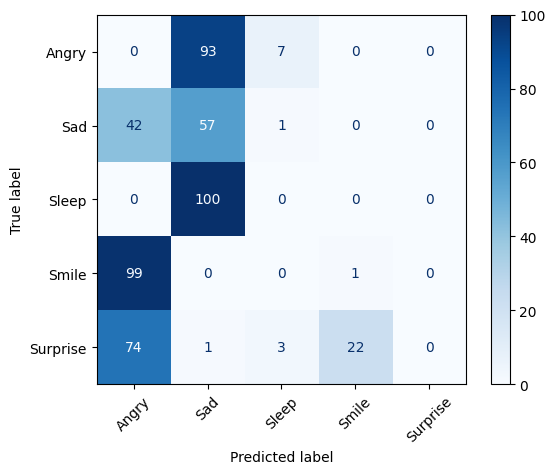

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(xticks_rotation=45, cmap='Blues')

In [ ]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00       100
         Sad       0.23      0.57      0.32       100
       Sleep       0.00      0.00      0.00       100
       Smile       0.04      0.01      0.02       100
    Surprise       0.00      0.00      0.00       100

    accuracy                           0.12       500
   macro avg       0.05      0.12      0.07       500
weighted avg       0.05      0.12      0.07       500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 301ms/step - accuracy: 0.4133 - loss: 1.3927 - val_accuracy: 0.9811 - val_loss: 0.7147
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - accuracy: 0.7779 - loss: 0.7123 - val_accuracy: 0.9978 - val_loss: 0.4123
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 237ms/step - accuracy: 0.9048 - loss: 0.4521 - val_accuracy: 0.9978 - val_loss: 0.2527
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 232ms/step - accuracy: 0.9695 - loss: 0.2670 - val_accuracy: 0.9989 - val_loss: 0.1674
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 233ms/step - accuracy: 0.9894 - loss: 0.1876 - val_accuracy: 0.9978 - val_loss: 0.1202
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 227ms/step - accuracy: 0.9915 - loss: 0.1265 - val_accuracy: 0.9978 - val_loss: 0.0905
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - accuracy: 0.9939 - loss: 0.0973 - val_accuracy: 0.9978 - val_loss: 0.0723
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 230ms/step - accuracy: 0.9961 - loss: 0

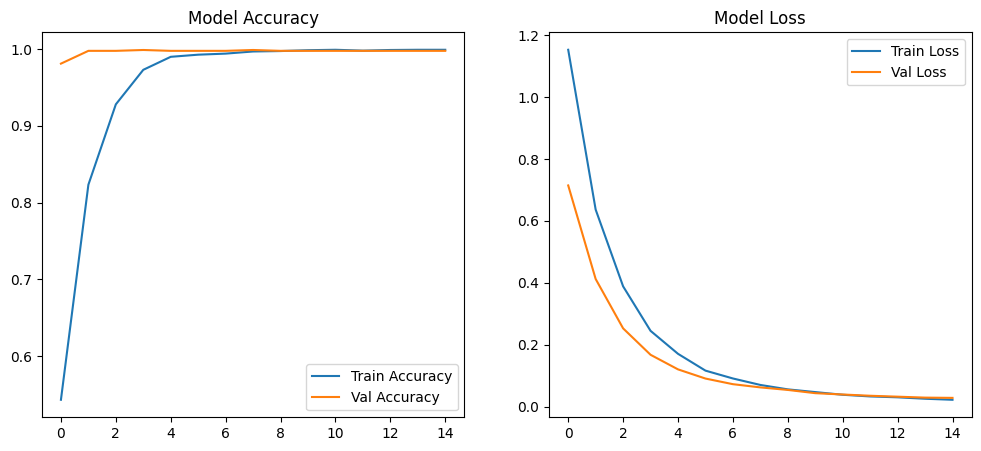

In [ ]:
#Just to get the history after studying optuna
model = build_model(
    base_model_name = best_values['base_model'],
    freeze_all = best_values['freeze_all'],
    freeze_except = best_values['freeze_except'],
    learning_rate = best_values['lr'],
    activation = best_values['activation'],
    num_layers = best_values['num_layers'],
    neurons = best_values['neurons'],
    num_classes = train_generator.num_classes
)

early_stop = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop],
    verbose=1
)

plot_history(history)

In [ ]:
#added video capture end part in jupyter

# Overall Interpretation :

- The best model parameters out of all combinations recognized by Optuna are Best trial
{'base_model': 'MobileNetV2', 'lr': 3.852277789415312e-05, 'freeze_all': True, 'freeze_except': 2, 'activation': 'relu', 'num_layers': 3, 'neurons': 64}

- The best value is 0.9977777600288391
- Training is stable , avoiding overfitting
-Train Accuracy: Increases steadily and reaches almost 1.0 by epoch 10.
-Validation Accuracy: Starts high and also remains close to 1.0 throughout.

Interpretation:
-The model learns very quickly and performs well on both training and validation data.
-Final metrics: val_accuracy = 0.9978, accuracy = 0.9990

-Train Loss and Val Loss both decrease rapidly and converge to very low values.

-Val loss stays very close to train loss, indicating good generalization.